# Spiking-RetinaNet generation

This script loads pre-trained RetinaNet object detector and performs its conversion to an equivalent SNN.

In [1]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['CMU']
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# SILENCE WARNINGS
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# GPU TEST 
print(tf.__version__)
print(tf.config.list_physical_devices())
print('Built with cuda: ', tf.test.is_built_with_cuda())
print('Built with gpu support: ', tf.test.is_built_with_gpu_support())
print('gpus: ', tf.config.list_physical_devices('GPU'))

2.3.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]
Built with cuda:  True
Built with gpu support:  True
gpus:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
##### PARAMETERS ###############################################
library_path = '.' #'./Github' # 
dataset_path = 'D:/UNIVERSIDAD/DTU/THESIS/DATASETS/COCO'# <--- Change to the path of the data
bbone_path = '.'
path_wd = './RNet_to_SNN_files' # <--- Data saving path
weights_dir = "pretrained_weights/avgpool" # <-- NN parameters path
batch_size = 1
image_shape = [896,1152]
verbose = 1
################################################################

if not os.path.exists(path_wd):
    os.mkdir(path_wd)

import site
import sys
site.addsitedir(os.path.join(library_path,'snn_toolbox'))
bbone_path = os.path.join(bbone_path, 'bbone_AVG')

In [4]:
from my_functions.retinanet_functions import swap_xy, convert_to_xywh, convert_to_corners, compute_iou, visualize_detections, AnchorBox, random_flip_horizontal, resize_and_pad_image, preprocess_data, LabelEncoder, DecodePredictions, RetinaNetLoss, RetinaNetLoss_Norm, RetinaNetClassificationLoss, RetinaNetBoxLoss, adapt_norm_to_output
from my_functions.retinanet_class import get_backbone, RetinaNet

## Setup of RetinaNet ANN
#### Training parameters (for building the model)

In [5]:
label_encoder = LabelEncoder()
learning_rate_fn = 0.001 #placeholder

#### Initialize model

In [6]:
tar_shape = image_shape+[3]

num_classes = 80

loss_fn = RetinaNetLoss(num_classes, batch_size=batch_size)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)

print('\n>1> Generating RetinaNet model')
resnet_backbone = get_backbone(bbone_path, input_shape = tar_shape)
model = RetinaNet(num_classes, resnet_backbone)
model.compile(loss=loss_fn, optimizer=optimizer)

print('      [ Model generated ] ')

print('\n>3> Load pretrained weights')
model.load_weights(tf.train.latest_checkpoint(weights_dir))

# BUILD MODEL

# tf.keras.backend.clear_session()
image = tf.keras.Input(shape=tar_shape, name="image")
predictions = model(image, training=False)
pred_model = tf.keras.Model(inputs=image, outputs=predictions)

model.summary()


>1> Generating RetinaNet model
Loading AveragePool backbone from [.\bbone_AVG]
      [ Model generated ] 

>3> Load pretrained weights
Model: "RetinaNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeaturePyramid (FeaturePyram ((None, 112, 144, 256), ( 31585152  
_________________________________________________________________
ClassHead (Sequential)       (None, None, None, 720)   4019920   
_________________________________________________________________
BoxHead (Sequential)         (None, None, None, 36)    2443300   
_________________________________________________________________
reshape (Reshape)            multiple                  0         
_________________________________________________________________
reshape_1 (Reshape)          multiple                  0         
_________________________________________________________________
concatenate (Concatenate)    (None, 1, 193347, 80)   

#### Load dataset

In [7]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    name = "coco/2017", 
    split=["train", "validation"], 
    with_info=True, 
    download = True,
    data_dir=dataset_path
)

print('\n>2> Dataset management')
autotune = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(10 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)


>2> Dataset management


## ANN-to-SNN conversion

In [8]:
from importlib import import_module
from snntoolbox.parsing.model_libs.keras_input_lib import load
from snntoolbox.parsing.model_libs.keras_input_lib import ModelParser
from snntoolbox.bin.utils import load_config

config_defaults_path = os.path.join(library_path,'snntoolbox/config_defaults')

### (I) Generate config file

In [9]:
print('\n>4> Create config file for SNN_Toolbox')

model_name = 'RNet'

import configparser
config = configparser.ConfigParser()

config['paths'] = {
    'path_wd': path_wd,             # Path to model.
    'dataset_path': path_wd,        # Path to dataset.
    'filename_ann': model_name      # Name of input model.
}

config['input'] = {
    'poisson_input': False,
    'norm_conv': False
}

config['tools'] = {
    'evaluate_ann': True,           # Test ANN on dataset before conversion.
    'normalize': True               # Normalize weights for full dynamic range.
}

config['normalization'] = {
    'percentile': 99.99,
    'method': 1,
    'num_to_norm': 1000, #12000,
    'save_interval': 100, #950    
}

config['simulation'] = {
    'simulator': 'INI',             # Chooses execution backend of SNN toolbox.
    'duration': 1000, #3000,                 # Number of time steps to run each sample.
    'num_to_test': 40,                      # How many test samples to run.
    'batch_size': batch_size,               # Batch size for simulation.
    'keras_backend': 'tensorflow'   # Which keras backend to use.
}

config['conversion'] = {
    'spike_code': 'temporal_mean_rate',
    'max2avg_pool': True
}

config['output'] = {
    'plot_vars': {                  # Various plots (slows down simulation).
        'v_mem',
        'error_t',
        'correl',
        }
}

config['custom'] = {
    'relu_pred': False
}

# Store config file.
config_filepath = os.path.join(path_wd, 'config')
with open(config_filepath, 'w') as configfile:
    config.write(configfile)

config = load_config(config_defaults_path)
config.read(config_filepath)

config_filepath = os.path.join(path_wd, 'config_FULL')
with open(config_filepath, 'w') as configfile:
    config.write(configfile)


>4> Create config file for SNN_Toolbox


### (II) Evaluate original model

In [10]:
print('\n>5> Evaluate Keras RetinaNet model')

num_to_test = config.getint('simulation', 'num_to_test')
batch_size = config.getint('simulation', 'batch_size')

score1 = model.evaluate(
    val_dataset.take(num_to_test),
    batch_size = batch_size,
    verbose = verbose
)


>5> Evaluate Keras RetinaNet model
40/40 [==============================] - 4s 106ms/step - loss: 0.7887


### (III) Parsing
As the original model is organized in subnetworks (keras.Models within the main Model) Some inner connections had to be performed manually.


In [11]:
print('\n>6> Parse the model')

model_parser = ModelParser(model, config)
name_map = {}
idx = 0
NN = model_parser.get_layer_iterable()

# FPN -------------------------------------------------------------------------------------------------------------------------

#> Backbone:
print('\n------------------------------------\n>> FPN\n------------------------------------')
subnet = NN[0].layers[0]
bbone_out_layers = [subnet.get_layer(layer_name) for layer_name in ["conv3_block4_add", "conv4_block6_add", "conv5_block3_add", "conv5_block3_add"]]
print('ResNet output layers = ', [layer.name for layer in bbone_out_layers], '\n')
idx,bbone_tails = model_parser.parse_subnet(subnet.layers, idx, prev_out_idx=None, in_layers=None, out_layers=bbone_out_layers)
print(idx, ' - ', bbone_tails)

#> Rest:
subnet = NN[0].layers[1:]
FPN_in = [subnet[i] for i in range(3)] + [subnet[10]]
FPN_out = [subnet[i] for i in range(-6,0) if i != -2]
print('FPN input layers = ', [layer.name for layer in FPN_in])
print('FPN output layers = ', [layer.name for layer in FPN_out], '\n')
idx,FPN_tails = model_parser.parse_subnet(subnet, idx, prev_out_idx=bbone_tails, in_layers=FPN_in, out_layers = FPN_out, repair=[subnet[-1]], special_relu=[subnet[-2]])
print(idx, ' - ', FPN_tails)

# Head 1 ----------------------------------------------------------------------------------------------------------------------

print('\n------------------------------------\n>> Classification subnet:\n------------------------------------')
subnet = NN[1].layers
resh = [NN[3]]
cat = [NN[5]]
head1_in = [subnet[0]]
head1_out = [subnet[-1]]
head1_tails = []
for tail in FPN_tails:
    idx, out_ref = model_parser.parse_subnet(subnet, idx, prev_out_idx=[tail], in_layers=head1_in, out_layers = head1_out)
    idx, out_ref = model_parser.parse_subnet(resh, idx, prev_out_idx=out_ref, in_layers=resh, out_layers = resh)
    head1_tails.append(out_ref[0])
print(idx, ' - ', head1_tails)

idx, head1_tails = model_parser.parse_subnet(cat, idx, prev_out_idx=head1_tails, in_layers=cat*5, out_layers = cat)
print(idx, ' - ', head1_tails)

# Head 2 ----------------------------------------------------------------------------------------------------------------------

print('\n------------------------------------\n>> Box-regression subnet:\n------------------------------------')
subnet = NN[2].layers
resh = [NN[4]]
cat = [NN[6]]
head2_in = [subnet[0]]
head2_out = [subnet[-1]]
head2_tails = []
for tail in FPN_tails:
    idx, out_ref = model_parser.parse_subnet(subnet, idx, prev_out_idx=[tail], in_layers=head2_in, out_layers = head2_out)
    idx, out_ref = model_parser.parse_subnet(resh, idx, prev_out_idx=out_ref, in_layers=resh, out_layers = resh)
    head2_tails.append(out_ref[0])
print(idx, ' - ', head2_tails)

idx, head2_tails = model_parser.parse_subnet(cat, idx, prev_out_idx=head2_tails, in_layers=cat*5, out_layers = cat)
print(idx, ' - ', head2_tails)

# Output ----------------------------------------------------------------------------------------------------------------------

subnet = [NN[7]]
idx, NN_tail = model_parser.parse_subnet(subnet, idx, prev_out_idx=head2_tails+head1_tails, in_layers=subnet*2, out_layers = subnet)


parsed_model = model_parser.build_parsed_RNet(loss_fn, optimizer)



>6> Parse the model

------------------------------------
>> FPN
------------------------------------
ResNet output layers =  ['conv3_block4_add', 'conv4_block6_add', 'conv5_block3_add', 'conv5_block3_add'] 

Skipping layer InputLayer.
Parsing layer ZeroPadding2D.
Parsing layer Conv2D.
Absorbing batch-normalization parameters into parameters of previous Conv2D.
Using BatchNorm axis 3.
Skipping layer BatchNormalization.
Using activation relu.
Skipping layer Activation.
Parsing layer ZeroPadding2D.
Parsing layer AveragePooling2D.
Parsing layer Conv2D.
Absorbing batch-normalization parameters into parameters of previous Conv2D.
Using BatchNorm axis 3.
Skipping layer BatchNormalization.
Using activation relu.
Skipping layer Activation.
Parsing layer Conv2D.
Absorbing batch-normalization parameters into parameters of previous Conv2D.
Using BatchNorm axis 3.
Skipping layer BatchNormalization.
Using activation relu.
Skipping layer Activation.
Parsing layer Conv2D.
Parsing layer Conv2D.
Absor

### (IV) Evaluate parsed model

In [12]:
print('\n>7> Evaluate parsed RetinaNet model')
score2 = parsed_model.evaluate(
  val_dataset.take(num_to_test),
  batch_size=batch_size,
  verbose = verbose
)


>7> Evaluate parsed RetinaNet model
40/40 [==============================] - 7s 166ms/step - loss: 0.7925


### (V) Normalization
Normalization was modified based on the channel_norm method in https://arxiv.org/pdf/1903.06530.pdf.
It was adapted to achieve compatibility with negative activations in the original model. (min, max) --> (0,1)


In [13]:
print('\n>8> Normalization')

norm_set = train_dataset

heads_layers = [
    ['85Conv2D','91Conv2D','97Conv2D','103Conv2D','109Conv2D'],
    ['86Conv2D','92Conv2D','98Conv2D','104Conv2D','110Conv2D'],
    ['87Conv2D','93Conv2D','99Conv2D','105Conv2D','111Conv2D'],
    ['88Conv2D','94Conv2D','100Conv2D','106Conv2D','112Conv2D'],
    ['89Conv2D','95Conv2D','101Conv2D','107Conv2D','113Conv2D'],
    ['116Conv2D','122Conv2D','128Conv2D','134Conv2D','140Conv2D'],
    ['117Conv2D','123Conv2D','129Conv2D','135Conv2D','141Conv2D'],
    ['118Conv2D','124Conv2D','130Conv2D','136Conv2D','142Conv2D'],
    ['119Conv2D','125Conv2D','131Conv2D','137Conv2D','143Conv2D'],
    ['120Conv2D','126Conv2D','132Conv2D','138Conv2D','144Conv2D']
]

cls_head = [item for sublist in heads_layers for item in sublist]


>8> Normalization


In [14]:
from snntoolbox.conversion.utils import channel_norm_J
channel_norm_J(parsed_model, config, norm_set, free_GB=5, equiv_layers=heads_layers)

import json
filepath = os.path.join(config.get('paths', 'path_wd'), 'channel_norm_J', config.get('normalization', 'percentile') + '_mod.json')
if os.path.isfile(filepath):
        with open(filepath) as f:
            scale_facs = json.load(f)

final_scale_facts = (scale_facs['120Conv2D'], scale_facs['89Conv2D'])
loss_fn_N = RetinaNetLoss_Norm(num_classes=num_classes, batch_size=batch_size,
    norm=adapt_norm_to_output(final_scale_facts, parsed_model.output_shape))
parsed_model.compile(loss=loss_fn_N, optimizer=optimizer)

Normalizing parameters with channel norm...
(*) Scale factors loaded from previous run: [ ./RNet_to_SNN_files\channel_norm_J\99.99.json ]



### (VI) Evaluate normalized model

In [15]:
print('\n>9> Evaluate normalized RetinaNet model')
score3 = parsed_model.evaluate(
  val_dataset.take(num_to_test),
  batch_size=batch_size,
  verbose = verbose
)


>9> Evaluate normalized RetinaNet model
40/40 [==============================] - 7s 170ms/step - loss: 0.9901


### (VII) Conversion

In [16]:
print('\n>11> Conversion of RetinaNet to SNN')

from importlib import import_module

def import_target_sim(config):

    sim_str = config.get('simulation', 'simulator')
    code_str = '_' + config.get('conversion', 'spike_code') \
        if sim_str == 'INI' else ''

    return import_module('snntoolbox.simulation.target_simulators.'
                         + sim_str + code_str + '_target_sim')

target_sim = import_target_sim(config)
print(target_sim)


>11> Conversion of RetinaNet to SNN
<module 'snntoolbox.simulation.target_simulators.INI_temporal_mean_rate_target_sim' from 'c:\\Users\\joaro\\Documents\\GitHub\\Spiking-RetinaNet\\snntoolbox\\simulation\\target_simulators\\INI_temporal_mean_rate_target_sim.py'>


In [17]:
tf.keras.backend.clear_session()
spiking_model = target_sim.SNN(config)
spiking_model.build_v2(parsed_model, loss_fn_N, optimizer, num_classes)

  0%|          | 0/148 [00:00<?, ?it/s]Initializing INI simulator...

Building spiking model...
>1> BUILDING SPIKING MODEL:

100%|██████████| 148/148 [00:17<00:00,  8.35it/s]


>2> COMPILING SPIKING MODEL:

100%|██████████| 149/149 [00:00<00:00, 203.65it/s]


>3> COMPUTING STATS FOR SPIKING MODEL:

Number of operations of ANN: 471366088956.0
Number of neurons: 293142780
Number of synapses: 58042707955

c:\Users\joaro\Documents\GitHub\Spiking-RetinaNet\snntoolbox\simulation\utils.py:1135: RuntimeWarning: overflow encountered in long_scalars
  self.num_synapses += self.num_neurons[i] * self.fanout[i]


### (VIII) Prepare test image

In [18]:
print('\n>12> Simulation of Spiking-RetinaNet')

test_set, dataset_info = tfds.load(
    name = "coco/2017", 
    split="validation", 
    with_info=True, 
    download = True,
    data_dir=dataset_path
)


>12> Simulation of Spiking-RetinaNet


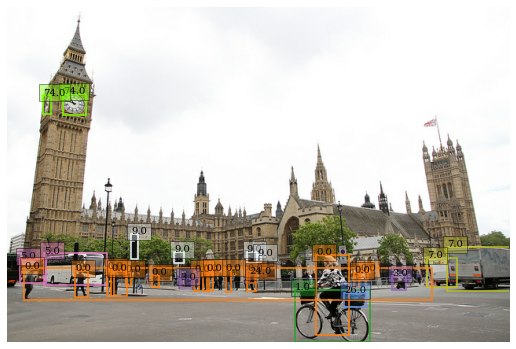

x.shape =  (1, 896, 1152, 3)
y_gt.shape =  (1, 193347, 5)
['bicycle', 'bus', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'clock', 'clock', 'truck', 'truck', 'traffic light', 'traffic light', 'person', 'person', 'bus', 'traffic light', 'traffic light', 'person', 'person', 'motorcycle', 'handbag', 'person', 'backpack', 'person', 'motorcycle', 'person']


In [19]:
n = 1000
int2str = dataset_info.features["objects"]["label"].int2str

from my_functions.retinanet_functions import view_sample, visualize_datasample

def view_sample(sample, showlabels=True):
    x = tf.cast(sample["image"], dtype=tf.float32)
    image_shape = tf.cast(tf.shape(x)[-3:-1], dtype=tf.float32)
    #ybox = sample["objects"]["bbox"]
    ybox = swap_xy(sample["objects"]["bbox"])
    #ybox = convert_to_corners(sample[1])
    ycls = tf.cast(sample["objects"]["label"], dtype=tf.float32)
    ybox = tf.stack( # [classes, x0, y0, x1, y1]
        [
            ybox[..., 0] * image_shape[1],
            ybox[..., 1] * image_shape[0],
            ybox[..., 2] * image_shape[1],
            ybox[..., 3] * image_shape[0],
        ],
        axis=-1)

    visualize_datasample(x,ybox,ycls, showlabels=showlabels)

def prepare_sample(sample):
    image = tf.cast(sample["image"], dtype=tf.float32)
    im, bbox, labels, ratio = preprocess_data(sample, return_ratio=True, rand_flip=False)
    x = tf.expand_dims(im, axis=0)
    ybox = convert_to_corners(bbox)
    ycls = labels
    bbox = tf.expand_dims(bbox, axis=0)
    labels = tf.expand_dims(labels, axis=0)
    x, y = label_encoder.encode_batch(x, bbox, labels)
    return x,y,ybox,ycls,image,ratio

for sample in test_set.take(n):
    pass

view_sample(sample)
x,y_gt,ybox,ycls,image,ratio = prepare_sample(sample)

print('x.shape = ', x.shape)
print('y_gt.shape = ', y_gt.shape)
print([int2str(aux) for aux in ycls])

In [20]:
im = tf.keras.Input(shape=tar_shape, name="image")
predictions = model(im, training=False)
pred_model = tf.keras.Model(inputs=im, outputs=predictions)

input_image = x

logs_dir = os.path.join(path_wd, 'logs_'+config.get('normalization','percentile'))
if not os.path.exists(logs_dir):
    os.mkdir(logs_dir)

### (IX) Simulate ANNs on test image

In [21]:
pred = [None]*4
pred[0] = pred_model.predict(input_image)
pred[1] = parsed_model.predict(input_image)

### (X) Analyze SNN
#### x-i Simulation: Print loss evolution and layer correlations

'Simulation and analyzing SNN'

't = [0.0 ---> 500.0]'

100%|██████████| 500/500 [03:59<00:00,  2.09it/s]
Saved correlation map for layer 30Conv2D  (500 ms) as [./RNet_to_SNN_files\logs_99.99\30Conv2D\30Conv2D  (500 ms).png]
Saved correlation map for layer 81Conv2D  (500 ms) as [./RNet_to_SNN_files\logs_99.99\81Conv2D\81Conv2D  (500 ms).png]
Saved correlation map for layer 147Concatenate[Output]  (500 ms) as [./RNet_to_SNN_files\logs_99.99\147Concatenate[Output]\147Concatenate[Output]  (500 ms).png]


't = [500.0 ---> 2000.0]'

100%|██████████| 1500/1500 [14:45<00:00,  1.69it/s]
Saved correlation map for layer 30Conv2D  (2000 ms) as [./RNet_to_SNN_files\logs_99.99\30Conv2D\30Conv2D  (2000 ms).png]
Saved correlation map for layer 81Conv2D  (2000 ms) as [./RNet_to_SNN_files\logs_99.99\81Conv2D\81Conv2D  (2000 ms).png]
Saved correlation map for layer 147Concatenate[Output]  (2000 ms) as [./RNet_to_SNN_files\logs_99.99\147Concatenate[Output]\147Concatenate[Output]  (2000 ms).png]


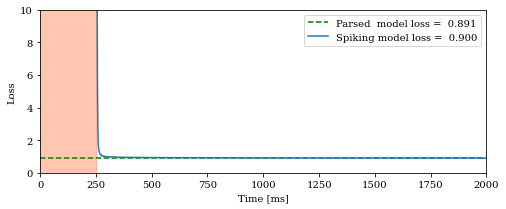

In [22]:
pred[2] = spiking_model.run_analysis(input_image, y=y_gt, save_path=logs_dir, t_to_check=[500, 2000],
        layers_to_check=['30Conv2D', '81Conv2D', '147Concatenate'],
        loss_ylim=[0,10], transient_dur=250, ignore_transient=True,
        )
pred[3] = pred[2]-pred[1]
titles = ["Original", "Parsed", "Spiking", "Approx_err"]

#### x-ii Loss benchmarking

In [23]:
loss_functions = [model.loss,parsed_model.loss,parsed_model.loss]
loss = [None]*3

for i,y_pred in enumerate(pred[:3]):
    loss[i] = loss_functions[i](y_gt, y_pred[0])
    print(titles[i]+' model loss = ', loss[i].numpy())

Original model loss =  0.8552733
Parsed model loss =  0.89056253
Spiking model loss =  0.8998003


#### x-iii Display detections 

Original model:
c:\Users\joaro\Documents\GitHub\Spiking-RetinaNet\my_functions\retinanet_functions.py:202: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.text(


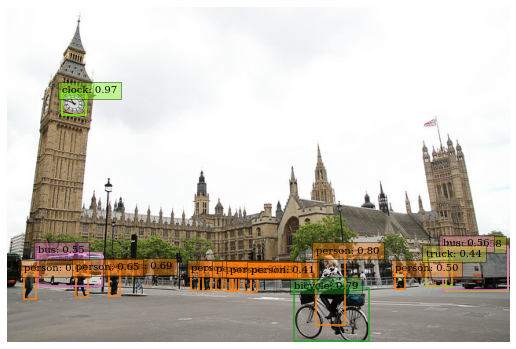

Parsed model:


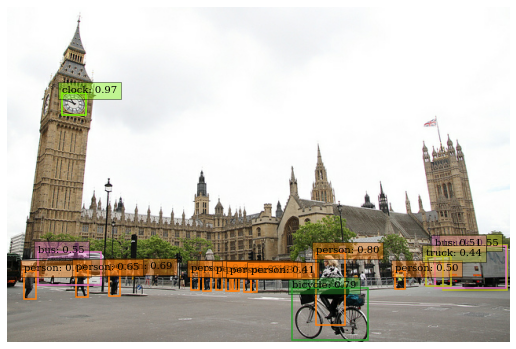

Converted model:


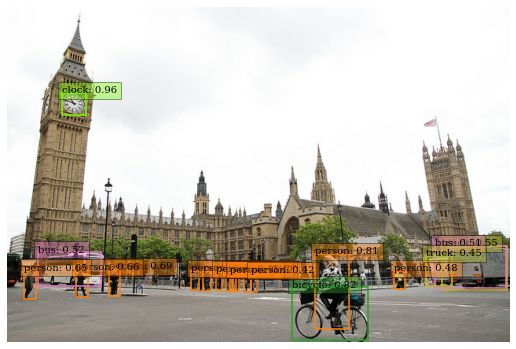

<AxesSubplot:>

In [24]:
from my_functions.retinanet_functions import DecodeNormalized
from my_functions.retinanet_functions import DecodePredictions
unfold = DecodeNormalized(lmbda_shift=final_scale_facts, numerical_precision = tf.float32)

int2str = dataset_info.features["objects"]["label"].int2str

print('Original model:')
det0 =  DecodePredictions(confidence_threshold=0.4, nms_iou_threshold=0.3)(input_image, pred[0])
nd0 = det0.valid_detections[0]

class_names = [
    int2str(int(x)) for x in det0.nmsed_classes[0][:nd0]
]
visualize_detections(
    image,
    det0.nmsed_boxes[0][:nd0]/ratio,
    det0.nmsed_classes[0][:nd0],
    det0.nmsed_scores[0][:nd0],
    class_names
)

print('Parsed model:')
decode = DecodePredictions(confidence_threshold=0.4, nms_iou_threshold=0.3)
det1 = decode(input_image, unfold(pred[1]))
nd1 = det1.valid_detections[0]
class_names = [
    int2str(int(x)) for x in det1.nmsed_classes[0][:nd1]
]
visualize_detections(
    image,
    det1.nmsed_boxes[0][:nd1]/ratio,
    det1.nmsed_classes[0][:nd1],
    det1.nmsed_scores[0][:nd1],
    class_names
)

print('Converted model:')
decode2 = DecodePredictions(confidence_threshold=0.4, nms_iou_threshold=0.3)
det2 = decode2(input_image, unfold(pred[2]))
nd2 = det2.valid_detections[0]

class_names = [
    int2str(int(x)) for x in det2.nmsed_classes[0][:nd2]
]
visualize_detections(
    image,
    det2.nmsed_boxes[0][:nd2]/ratio,
    det2.nmsed_classes[0][:nd2],
    det2.nmsed_scores[0][:nd2],
    class_names
)

#### x-iv Full output comparison

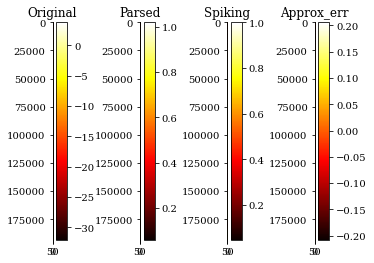


Box regression output:


<Figure size 432x288 with 0 Axes>

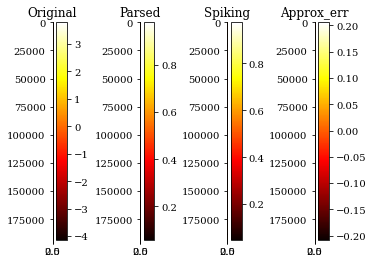


Classification output:


<Figure size 432x288 with 0 Axes>

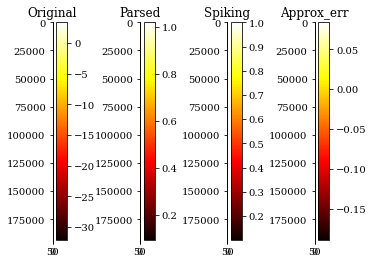

<Figure size 432x288 with 0 Axes>

In [25]:
fig, axs = plt.subplots(1,len(pred))
for j in range(len(pred)):
    ax = axs[j].imshow(pred[j][0][0], cmap='hot', interpolation='nearest')
    fig.colorbar(ax, ax=axs[j])
    axs[j].set_title(titles[j])
plt.show()
plt.clf()

print('\nBox regression output:')
fig, axs = plt.subplots(1,len(pred))
for j in range(len(pred)):
    ax = axs[j].imshow(pred[j][0][0][:,:4], cmap='hot', interpolation='nearest')
    fig.colorbar(ax, ax=axs[j])
    axs[j].set_title(titles[j])
plt.show()
plt.clf()

print('\nClassification output:')
fig, axs = plt.subplots(1,len(pred))
for j in range(len(pred)):
    ax = axs[j].imshow(pred[j][0][0][:,4:], cmap='hot', interpolation='nearest')
    fig.colorbar(ax, ax=axs[j])
    axs[j].set_title(titles[j])
plt.show()
plt.clf()

#### x-v Normalized outputs comparison

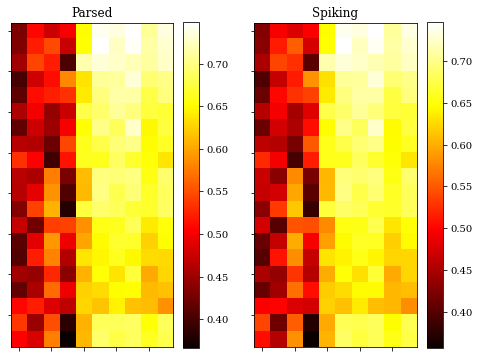

<Figure size 432x288 with 0 Axes>

In [26]:
fig, axs = plt.subplots(1,2, figsize=(8,6))
for j in range(2):
    ax = axs[j].imshow(pred[j+1][0][0][:20, :10], cmap='hot', interpolation='nearest')
    fig.colorbar(ax, ax=axs[j])
    axs[j].set_title(titles[j+1])
    axs[j].set_xticklabels([])
    axs[j].set_yticklabels([])
plt.show()
plt.clf()

#### x-vi Decoded outputs comparison (normalized outputs scaled back to original size)

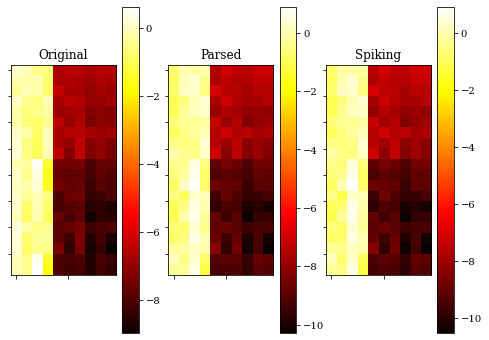

<Figure size 432x288 with 0 Axes>

In [27]:
fig, axs = plt.subplots(1,3, figsize=(8,6))
for j in range(3):   
    if j==0:
        dec = pred[j]
    else:
        dec = unfold(pred[j])
    ax = axs[j].imshow(dec[0][0][:20, :10], cmap='hot', interpolation='nearest')
    fig.colorbar(ax, ax=axs[j])
    axs[j].set_title(titles[j])
    axs[j].set_xticklabels([])
    axs[j].set_yticklabels([])
plt.show()
plt.clf()